x86_64
Linux-5.3.0-46-generic-x86_64-with-Ubuntu-18.04-bionic
Linux
search_capture
camera num2
model set


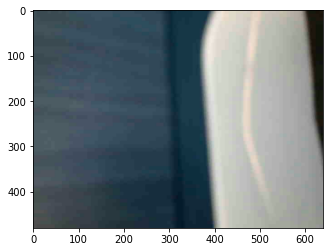

1 7501
2 6151
3 4943
4 -1
5 5300
6 -1
7 7489
led count


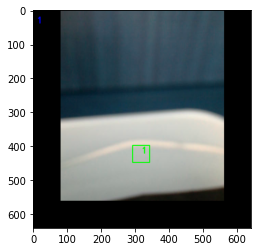

In [1]:
import cv2
import tensorflow as tf
import platform
import subprocess
import sys
import getpass
from pathlib import Path
import matplotlib.pyplot as plt
import math
import numpy as np

sys.path.append("./Rcb4Lib")
sys.path.append("./ledCamera")

from Rcb4BaseLib import Rcb4BaseLib
from led_camera import ledCamera

print(platform.machine())
print(platform.platform())
print(platform.system())

rcb4 = Rcb4BaseLib()
ledCam = ledCamera()

crnt_path = Path.cwd()
model_path = crnt_path / "ledCamera" / "phots-model-light.hdf5"

ledCam.model_set(str(model_path))
#ledCam.camera_view()
ret, frame = ledCam.cap.read()

plt.imshow(frame)
plt.show()

rcb4.open('/dev/ttyUSB0',115200,1.3)

#rcb4.setSingleServo(5,1,7500,100)
# 1: 5000->left,7500->center,10000->right
# 2: 5000->up,7500->center,10000-> under
# 3: 5000->under, 7500->center, 10000->up
# 5: 5000->under, 7500->center, 10000->up
# 7: 6800->under, 8000->up

for i in range(1,8):
    _,get_data = rcb4.getSinglePos (i,1)
    print(i,get_data)
    ret, frame = ledCam.cap.read()

height = frame.shape[0]
width = frame.shape[1]
center = (int(width/2), int(height/2))
angle = 270
scale = 1

trans = cv2.getRotationMatrix2D(center, angle, scale)
# height <--> width 
frame2 = cv2.warpAffine(frame,trans,(width,width))
    
center,cap_img = ledCam.led_count(frame2)
plt.imshow(cap_img)

#print(ledCam.cap.set(5,30))
#print(ledCam.cap.get(5))

plt.show()

# 0 posision
rcb4.setSingleServo(1,1,7500,100)
rcb4.setSingleServo(2,1,7500,100)
rcb4.setSingleServo(3,1,7500,100)
rcb4.setSingleServo(5,1,7500,100)
rcb4.setSingleServo(6,1,7500,100)
rcb4.setSingleServo(7,1,7500,100)


sv1=rcb4.getSinglePos(1,1)
sv2=rcb4.getSinglePos(2,1)
sv3=rcb4.getSinglePos(3,1)
sv4=rcb4.getSinglePos(4,1)
sv5=rcb4.getSinglePos(5,1)
sv6=rcb4.getSinglePos(6,1)
sv7=rcb4.getSinglePos(7,1)


In [2]:

am1=120
am2=120
am3=200
am4=180

def get_theta(sv_no):
    _,sv = rcb4.getSinglePos(sv_no,1)
    rad = (7500 - sv) / 5000 * math.pi
    return rad

def get_degree(sv_no):
    rad = get_theta(sv_no)
    degree = 180 * rad / math.pi
    return degree

def set_degree(sv_no,deg,late=200):
    rad = deg * math.pi / 180
    set_theta(sv_no,rad,late)

def set_theta(sv_no,rad,late=200):
    sv = int(7500 - 5000 * rad / math.pi)
    #print(sv)
    if(sv < 3500 or 11500 < sv):
        return False
    rcb4.setSingleServo(sv_no,1,sv,late)
    return sv

#P = (x,y)
# O = (0,0)
# OP^2 = x^2 + y^2
# sv2 = gamma - beta
# sv3 = pi - alpha
# OP^2 = am1^2 + am2^2 - 2*am1*am2*cos(alpha)
# am2^2 = am1^2 + op^2 - 2*am1*am2*cos(bata)
# alpha = arccos((am1^2 + am2^2 - op^2) / (2*am1*am2))
# beta = arcdos((op^2 + am1^2 - am2^2) / 2*am1*am2))
# gamma = arccos(y / op)

# 2次元で指定
# l = 横軸
# h = 高さ

def theta2degree(theta):
    return round((180 * theta / math.pi),1)

def set_lh2theta(l,h,late=200):
    op2 = l**2 + h**2
    #print(op2)
    op = math.sqrt(op2)
    #print(op)
    alpha = math.acos((am2**2 + am3**2 - op2) / (2 * am2 * am3))
    beta = math.acos((op2 + am2**2 - am3**2) / (2 * am2 * am3))
    gamma = math.acos( h / op )
    sv2 = gamma - beta
    sv3 = math.pi - alpha
    sv5 = math.pi - sv2 - sv3
    
    print("sv2:{0},sv3:{1},sv5:{2}".format(theta2degree(sv2),theta2degree(sv3),theta2degree(sv5)))
    set_theta(2,-sv2,late)
    set_theta(3,sv3,late)
    set_theta(5,sv5,late)
    
    return True
    
# 3次元で指定
def set_xyz2theta(x,y,z,late=200):
    z0 = z + am4
    sv1 = math.atan(y/x)
    print("sv1:{0}".format(theta2degree(sv1)))
    xy = math.sqrt(x**2 + y**2)
    set_theta(1,sv1,late)
    set_lh2theta(xy,z0,late)
    
    return True
    
def get_all_degree():
    sv_list = []
    text = ""
    for i in range(1,8):
        deg = get_degree(i)
        text += "sv{0}:{1:.2f},".format(i,deg)
        sv_list.append(deg)
    print(text)
    return sv_list
          
def all_close():
    ledCam.release()
    rcb4.close()

sv1:0.0
sv2:-5.9,sv3:85.7,sv5:100.2
sv1:0.65,sv2:1.04,sv3:86.29,sv4:270.04,sv5:99.36,sv6:270.04,sv7:0.04,
led count


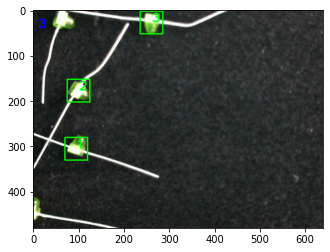

-225 65
sv1:1.6
sv2:-15.1,sv3:90.8,sv5:104.3
led count


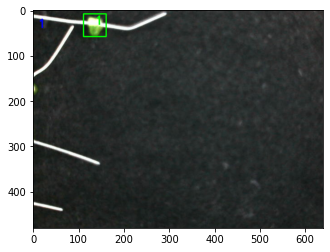

In [7]:
import time
#set_degree(5,120)
x0 = 320
y0 = 240

setx = 160
sety = 0

set_xyz2theta(setx,sety,0,200)
time.sleep(3)
get_all_degree()
for i in range(10):
    ledCam.cap.read()

ret, frame = ledCam.cap.read()
center,cap_img = ledCam.led_count(frame)
plt.imshow(cap_img)
plt.show()

x,y = center[0]
dx = x - x0
dy = y - y0

print(dx,dy)

setx = setx + dx/16
sety = sety + dy/16

set_xyz2theta(setx,sety,0,200)

time.sleep(3)

for i in range(10):
    ledCam.cap.read()

ret, frame = ledCam.cap.read()
center,cap_img = ledCam.led_count(frame)
plt.imshow(cap_img)
plt.show()

In [5]:
    set_degree(7,0)

led count


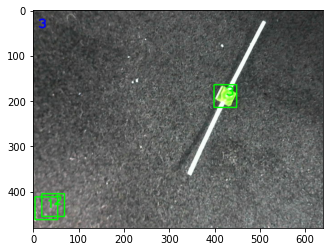

[(29, 436), (44, 429), (424, 189)]


In [101]:
for i in range(10):
    ledCam.cap.read()

ret, frame = ledCam.cap.read()
#plt.imshow(frame)
#plt.show()

#trans = cv2.getRotationMatrix2D(center, angle, scale)
# height <--> width 
#frame2 = cv2.warpAffine(frame,trans,(width,width))
    
center,cap_img = ledCam.led_count(frame)
plt.imshow(cap_img)

#print(ledCam.cap.set(5,30))
#print(ledCam.cap.get(5))

plt.show()

print(center)

In [ ]:
import time
def calib_servo(sv_no):
    rcb4.setSingleServo(sv_no,1,5000,200)
    
    for i in range(10):
        time.sleep(1)
        _,get_sv = rcb4.getSinglePos(sv_no,1)
        print(i,get_sv)
        
        
    time.sleep(1)
    for set_sv in range(5000,10000,100):
        rcb4.setSingleServo(sv_no,1,set_sv,200)
        time.sleep(3)
        _,get_sv=rcb4.getSinglePos(sv_no,1)
        print(set_sv,get_sv)
        if set_sv == 7500:
            return
        
calib_servo(1)


In [ ]:
_,get = rcb4.getSinglePos(1,1)
print(get)
set_sv = 15000-get
print(set_sv)
rcb4.setSingleServo(1,1,set_sv,200)

time.sleep(3)
_,get = rcb4.getSinglePos(1,1)
print(get)

In [ ]:
rcb4.setSingleServo(1,1,7480,100)
time.sleep(4)
print(rcb4.getSinglePos(1,1))

In [ ]:
time.sleep(3)
print(rcb4.getSinglePos(1,1))